In [21]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

from gensim.models import Word2Vec

In [22]:
import json

# Define a function to load data from a file
def load_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Load the data from the three files
test_data_path = 'Laptop_Review_Test_BioLabels.json'
train_data_path = 'Laptop_Review_Train_BioLabels.json'
val_data_path = 'Laptop_Review_Validation_BioLabels.json'

test_data = load_data(test_data_path)
train_data = load_data(train_data_path)
val_data = load_data(val_data_path)
# Adjusting approach to properly display the data structure and a sample

# Function to safely extract samples from data which might be a dictionary or list
def get_sample(data):
    if isinstance(data, dict):
        # If the data is a dictionary, return a part of it
        return {k: data[k] for k in list(data)[:2]}
    elif isinstance(data, list):
        # If the data is a list, return the first two elements
        return data[:2]
    else:
        return "Unsupported data type"

# Get samples from each dataset
test_data_sample = get_sample(test_data)
train_data_sample = get_sample(train_data)
val_data_sample = get_sample(val_data)

{
    "test_data_sample": test_data_sample,
    "train_data_sample": train_data_sample,
    "val_data_sample": val_data_sample,
}

{'test_data_sample': {'1': {'text': 'Boot time is super fast , around anywhere from 35 seconds to 1 minute .',
   'labels': ['B',
    'I',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O']},
  '2': {'text': 'tech support would not fix the problem unless I bought your plan for $ 150 plus .',
   'labels': ['B',
    'I',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O']}},
 'train_data_sample': {'1': {'text': 'I charge it at night and skip taking the cord with me because of the good battery life .',
   'labels': ['O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'B',
    'I',
    'O']},
  '2': {'text': 'it is of high quality , has a killer GUI , is extremely stable , is highly expandable , is bundled with lots of very good applications , is easy t

In [23]:
import pandas as pd
# Convert dictionary data to DataFrame
train_df = pd.DataFrame.from_dict(train_data, orient='index').reset_index(drop=True)
test_df = pd.DataFrame.from_dict(test_data, orient='index').reset_index(drop=True)
val_df = pd.DataFrame.from_dict(val_data, orient='index').reset_index(drop=True)

# Display a sample from the train DataFrame to check preprocessing
train_df.head()

,text,labels
0,I charge it at night and skip taking the cord ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"it is of high quality , has a killer GUI , is ...","[O, O, O, O, B, O, O, O, O, B, O, O, O, O, O, ..."
2,Easy to start up and does not overheat as much...,"[O, O, B, I, O, O, O, O, O, O, O, O, O, O]"
3,Great laptop that offers many great features !,"[O, O, O, O, O, O, B, O]"
4,One night I turned the freaking thing off afte...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [24]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np

# Prepare sentences for Word2Vec training
train_sentences = train_df['text'].apply(lambda x: x.split()).tolist()
test_sentences = test_df['text'].apply(lambda x: x.split()).tolist()
val_sentences = val_df['text'].apply(lambda x: x.split()).tolist()

# Combine sentences from all datasets
all_sentences = train_sentences + test_sentences + val_sentences

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=all_sentences, vector_size=512, window=5, min_count=1, sg=0)

# Save the model
word2vec_model.save('word2vec_model')

#example
examples_sentence = train_sentences[0]

# Get the word vectors for the example sentence
example_vectors = [word2vec_model.wv[word] for word in examples_sentence if word in word2vec_model.wv.key_to_index]

# Now similarly, convert all the sentences in train_df to vectors
train_df['vectors'] = train_df['text'].apply(lambda x: [word2vec_model.wv[word] for word in x.split() if word in word2vec_model.wv.key_to_index])
val_df['vectors'] = val_df['text'].apply(lambda x: [word2vec_model.wv[word] for word in x.split() if word in word2vec_model.wv.key_to_index])
test_df['vectors'] = test_df['text'].apply(lambda x: [word2vec_model.wv[word] for word in x.split() if word in word2vec_model.wv.key_to_index])


In [25]:
#print the length of text of first instance in train_df
print(len(train_df['text'][2].split()))
print(len(train_df['vectors'][2]))

14
14


In [26]:
# checking what is the maximum length of the text by checking len of list of vectors
max_len = max([len(x) for x in train_df['vectors']])
print(max_len)

78


In [27]:
# pad the vectors to have the same length
def pad_vectors(vectors, target_length=60):
    # Get the current length of the vectors
    current_length = len(vectors)

    # If the current length is less than the target length, pad the vectors
    if current_length < target_length:
        # Calculate the number of vectors to be added
        num_to_add = target_length - current_length

        # Add the vectors
        vectors += [np.zeros(512) for _ in range(num_to_add)]

    # if the current length is greater than the target length, slice the vectors
    elif current_length > target_length:
        vectors = vectors[:target_length]

    return vectors

# Pad the vectors in the train, test, and val DataFrames
train_df['vectors'] = train_df['vectors'].apply(lambda x: pad_vectors(x, target_length=60))
val_df['vectors'] = val_df['vectors'].apply(lambda x: pad_vectors(x, target_length=60))
test_df['vectors'] = test_df['vectors'].apply(lambda x: pad_vectors(x, target_length=60))

In [28]:
#get all the unique labels
unique_labels = set()
for labels in train_df['labels']:
    unique_labels.update(labels)

In [29]:
print(len(unique_labels)) # B, I, O

3


In [30]:
#padding the labels as well
def pad_labels(labels, target_length=60):
    # Get the current length of the labels
    current_length = len(labels)
    
    # If the current length is less than the target length, pad the labels
    if current_length < target_length:
        # Calculate the number of labels to be added
        num_to_add = target_length - current_length
        
        # Add the labels
        labels += ['O' for _ in range(num_to_add)]
    
    # if the current length is greater than the target length, slice the labels
    elif current_length > target_length:
        labels = labels[:target_length]

    return labels

In [31]:
#giving all labels index
labels_to_index = {label: index for index, label in enumerate(unique_labels)}
print(labels_to_index)

{'I': 0, 'B': 1, 'O': 2}


In [32]:
# Function to convert labels to indices
def labels_to_indices(labels, label_to_index):
    return [[label_to_index[label] for label in sentence_labels] for sentence_labels in labels]


In [33]:
# Padding the labels using the provided function
def pad_all_labels(label_sequences, target_length=60):
    return [pad_labels(labels, target_length) for labels in label_sequences]

# Applying the padding function to train, validation, and test label sequences
train_labels_padded = pad_all_labels(train_df['labels'], 60)
val_labels_padded = pad_all_labels(val_df['labels'], 60)
test_labels_padded = pad_all_labels(test_df['labels'], 60)

# Convert label sequences to indices with padding applied
train_labels_indices_padded = labels_to_indices(train_labels_padded, labels_to_index)
val_labels_indices_padded = labels_to_indices(val_labels_padded, labels_to_index)
test_labels_indices_padded = labels_to_indices(test_labels_padded, labels_to_index)

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

In [35]:
num_classes = len(labels_to_index)

In [36]:
# Model parameters
input_dim = 512  # Size of the word vectors
hidden_dim = 256  # RNN hidden state size
output_dim = num_classes  # Number of output classes
num_layers = 1  # Number of RNN layers

model = RNNModel(input_dim, hidden_dim, output_dim, num_layers)
loss_function = nn.CrossEntropyLoss()  # Suitable for classification tasks
optimizer = optim.Adam(model.parameters())

In [37]:
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset

# Updated create_dataset function to handle padded labels
def create_dataset(vectors, labels_indices):
    vectors_tensor = torch.tensor(vectors, dtype=torch.float)
    labels_tensor = torch.tensor(labels_indices, dtype=torch.long)
    dataset = TensorDataset(vectors_tensor, labels_tensor)
    return DataLoader(dataset, batch_size=32, shuffle=True)

# Creating DataLoaders for the training and validation sets
train_loader = create_dataset(train_df['vectors'].tolist(), train_labels_indices_padded)
val_loader = create_dataset(val_df['vectors'].tolist(), val_labels_indices_padded)

# Tracking variables
training_losses = []
validation_losses = []
training_f1_scores = []
validation_f1_scores = []

epochs = 10
for epoch in range(epochs):
    model.train()
    train_losses = []
    val_losses = []
    train_preds, train_true = [], []
    val_preds, val_true = [], []
    
    # Training loop
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs.view(-1, num_classes), labels.view(-1))
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        _, predicted = torch.max(outputs.data, 2)
        train_preds.extend(predicted.view(-1).numpy())
        train_true.extend(labels.view(-1).numpy())
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_function(outputs.view(-1, num_classes), labels.view(-1))
            val_losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 2)
            val_preds.extend(predicted.view(-1).numpy())
            val_true.extend(labels.view(-1).numpy())
    
    # Calculate F1 scores
    train_f1 = f1_score(train_true, train_preds, average='macro')
    val_f1 = f1_score(val_true, val_preds, average='macro')
    
    # Store metrics
    training_losses.append(np.mean(train_losses))
    validation_losses.append(np.mean(val_losses))
    training_f1_scores.append(train_f1)
    validation_f1_scores.append(val_f1)
    
    print(f'Epoch {epoch+1}, Training Loss: {training_losses[-1]}, Validation Loss: {validation_losses[-1]}, Training F1: {training_f1_scores[-1]}, Validation F1: {validation_f1_scores[-1]}')

Epoch 1, Training Loss: 0.2742898900961054, Validation Loss: 0.15072711450713022, Training F1: 0.3389711987618216, Validation F1: 0.3278409530440164
Epoch 2, Training Loss: 0.14362098893214917, Validation Loss: 0.12061597726174764, Training F1: 0.3483744578779197, Validation F1: 0.3278409530440164
Epoch 3, Training Loss: 0.1251406679893362, Validation Loss: 0.11441313262496676, Training F1: 0.33114218401586226, Validation F1: 0.3344490857261499
Epoch 4, Training Loss: 0.1226374733036962, Validation Loss: 0.11181795703513282, Training F1: 0.3355537440763199, Validation F1: 0.34086771856133
Epoch 5, Training Loss: 0.11892184512368564, Validation Loss: 0.10862594204289573, Training F1: 0.32956473489468835, Validation F1: 0.33006455771272936
Epoch 6, Training Loss: 0.11651719181702055, Validation Loss: 0.10589268590722765, Training F1: 0.32802783021330567, Validation F1: 0.3278409530440164
Epoch 7, Training Loss: 0.11384152081506006, Validation Loss: 0.10460838888372694, Training F1: 0.328

Text(0, 0.5, 'Loss')

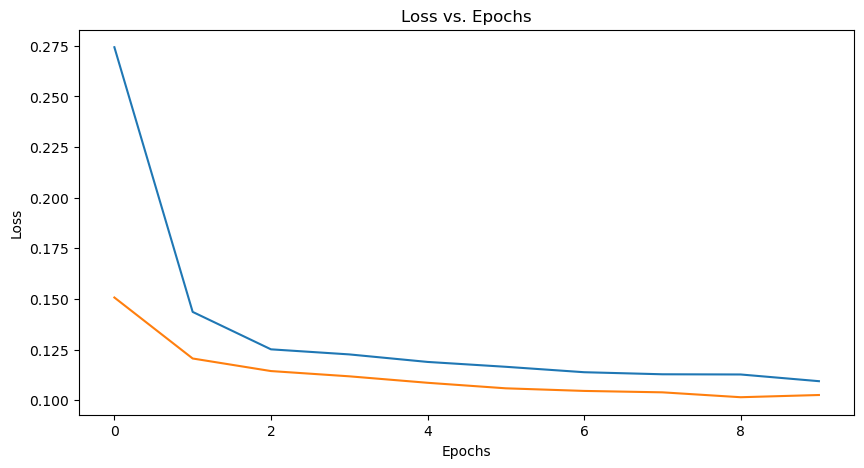

In [38]:
import matplotlib.pyplot as plt

# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')